In [299]:

import pymongo
from pymongo import MongoClient
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from bson.son import SON
from bson.code import Code
import json
import pandas as pd
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
# These are packages need for natural language processing:
import nltk
from __future__ import division, unicode_literals 
from textblob import TextBlob as tb
import math
from datetime import datetime
from dateutil import parser

In [6]:
client = MongoClient()
#creating mbf database (mbf = "meta beauty file")
mbf = client.dsbc.mbf
# mbf.remove()


In [ ]:
with open('meta_Beauty.json') as meta_beauty_file:
    for line in meta_beauty_file:
        meta_f = json.loads(line)  
        #only work when using json.loads() not json.load() 
        mbf.insert(meta_f)
        
#can't do json.load(meta_beautfy_file) since meta_beauty_file has the form "{...}{...}{...}" --> not json
#json.load(line) does not work since line is  string

In [59]:
# "categories": [["Beauty", "Skin Care",...]] --> need to $unwind
# use "categories.0" get the innner list.

#Skin_care = mbf.find({"categories.0": ["Beauty"]})

pipeline  = [{"$unwind":"$categories"},
             {"$match":{"categories":{"$all":["Face","Creams & Moisturizers"]}}},
             {"$project":{"_id":0,"asin":1,"title":1,"price":1}},
             {"$out": "product_info"}]
# "$out" write the result into new collection
# "$all" find all list that contains everything in queries
mbf.aggregate(pipeline)

In [12]:
product_info = client.dsbc.product_info

In [13]:
# name = product_info.find({}, {"_id":0,"asin":1})
# id_list  = {}
# for id_num in name:
#     id_list.append(id_num["asin"])

In [15]:
name = product_info.find({}, {"_id":0,"asin":1,"title":1,"price":1})
id_list  = {}
for id_num in name:
    try:
        id_list[id_num["asin"]]=[id_num["title"],id_num["price"]]
    except:
        pass


In [82]:
#id_list.keys()

In [17]:
#Creating database for reviews beauty file
rbf = client.dsbc.rbf

In [10]:

with open('reviews_Beauty.json') as reviews_beauty_file:
    for line in reviews_beauty_file:
        review = json.loads(line)  
        rbf.insert(review)
        

In [18]:
#new database for selective items
ndb = client.dsbc.ndb

In [85]:
beauty_item_tb = {id_list.keys()[0] : id_list.values()[0], 
                    "Reviews" : [], "rating":{"Five_star":0, 
                                              "Four_star":0,
                                              "Three_star":0,
                                              "Two_star":0,
                                              "One_star":0}}
match_list = rbf.find({"asin":{"$in": [id_list.keys()[0]]}})

for i in match_list:
    beauty_item_tb["Reviews"].append(tb(i['reviewText']))

#TF-IDF method

tf(word, blob) computes "term frequency" which is the number of times a word appears in a document blob, normalized by dividing by the total number of words in blob. We use TextBlob for breaking up the text into words and getting the word counts.

n_containing(word, bloblist) returns the number of documents containing word. A generator expression is passed to the sum() function.

idf(word, bloblist) computes "inverse document frequency" which measures how common a word is among all documents in bloblist. The more common a word is, the lower its idf. We take the ratio of the total number of documents to the number of documents containing word, then take the log of that. Add 1 to the divisor to prevent division by zero.
tfidf(word, blob, bloblist) computes the TF-IDF score. It is simply the product of tf and idf.

In [63]:
def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

In [66]:
for i, blob in enumerate(beauty_item_info['Reviews']):
    print i, blob.sentiment

0 Sentiment(polarity=0.3722222222222222, subjectivity=0.6432098765432098)
1 Sentiment(polarity=0.2, subjectivity=0.6)


In [65]:
beauty_item_info['Reviews']

[TextBlob("I just started using this, so I'm not sure yet of the long-term effects, but overall it's a great moisturizer.  I'm fairly picky about moisturizers, since I tend to be really oily (my whole face, too...lucky me).  This one seems like it might be a winner.  It absorbed nicely and my skin did look and feel great after using it. It did lose one star, though, because of the price- it's a bit steep."),
 TextBlob("I bought it for a collagen moisturizer and immediately found it cleared my breakouts. I still use an under eye cream since I am 56 but this cream is miraculous. It soaks in so fast you can't believe it and it not greasy or shiny for someone with oily skin.")]

In [90]:
for i, blob in enumerate(beauty_item_tb['Reviews']):
    print("Top words in document {}".format(i + 1))
    scores = {word: tfidf(word, blob, beauty_item_tb['Reviews']) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:10]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

Top words in document 1
	Word: winner, TF-IDF: 0.0
	Word: just, TF-IDF: 0.0
	Word: feel, TF-IDF: 0.0
	Word: look, TF-IDF: 0.0
	Word: because, TF-IDF: 0.0
	Word: star, TF-IDF: 0.0
	Word: tend, TF-IDF: 0.0
	Word: really, TF-IDF: 0.0
	Word: to, TF-IDF: 0.0
	Word: seems, TF-IDF: 0.0
Top words in document 2
	Word: breakouts, TF-IDF: 0.0
	Word: am, TF-IDF: 0.0
	Word: soaks, TF-IDF: 0.0
	Word: someone, TF-IDF: 0.0
	Word: still, TF-IDF: 0.0
	Word: cream, TF-IDF: 0.0
	Word: believe, TF-IDF: 0.0
	Word: eye, TF-IDF: 0.0
	Word: for, TF-IDF: 0.0
	Word: fast, TF-IDF: 0.0


###Based on the above analysis, we can see that it's not very helpful to look at TF-IDF

# Document Summarization

In [193]:
def get_b_product (i):
    beauty_item_info = {id_list.keys()[i] : id_list.values()[i], 
                    "Reviews" : '', "rating":{"Five_star":0, 
                                              "Four_star":0,
                                              "Three_star":0,
                                              "Two_star":0,
                                              "One_star":0}}
    match_list = rbf.find({"asin":{"$in": [id_list.keys()[i]]}})

    for i in match_list:
        beauty_item_info["Reviews"]+=(i['reviewText'])
        if i['overall'] == 5.0:
            beauty_item_info["rating"]["Five_star"] += 1
        elif i['overall'] == 4.0:
            beauty_item_info["rating"]["Four_star"] += 1
        elif i['overall'] == 3.0:
            beauty_item_info["rating"]["Three_star"] += 1
        elif i['overall'] == 2.0:
            beauty_item_info["rating"]["Two_star"] += 1
        else:
            beauty_item_info["rating"]["One_star"] += 1
    return beauty_item_info

In [196]:
get_b_product(100)

{u'B002FP4ADG': [u'Decleor Hydra Floral Moisturizing Cream - Tube 1.35 oz.',
  47.88],
 u'Reviews': u"Great service, my order arrived earlier than the expected 7-10 day shipping through USPS. I have used this product before and love it. I was happy to find this great deal through Amazon. I ordered two of these moisturizers and the Decleor boxes that the moisturizers came in were a little dinged up after making their way through US mail, but the jars inside were not damaged at all, so  I have no complaints. Would recommend this seller!The pros: You use a very tiny little bit, and it goes a long way. Feels very non-greasy but still quenches my skin's thirst.The con: Price. Although obviously you could do worse, this does cost more than other brands.All in all, I love this moisturizer and have been using it for years.I'm fussy about what I put on my 47 year old face these days. Luckily good family genes help me to look younger than my years, but I still moisturize and use sun screen. Bein

In [185]:
N = 100 #number of words to consider
Cluster_threshold = 5 #distance between two words to consider
Top_sentences = 5 #number of sentences to return for a "top n" summary

###This approach is based on "The Automatic Creation of Literature Abstracts" by H.P.Luhn

In [186]:
def _score_sentences(sentences, important_words,Cluster_threshold = 5):
    scores = []
    sentence_idx = -1
    
    #word_tokenize(s) split a sentence and find all the words and punctuations
    for s in [nltk.tokenize.word_tokenize(s) for s in sentences]:
        sentence_idx += 1
        word_idx =[]
        
        # This function check whether any important words occur in the sentence
        # if  there is, record the location of the important word in the sentence
        for w in important_words:
            try:
                word_idx.append(s.index(w))
            except ValueError, e:
                pass
        word_idx.sort()
        
        #If there is no important words in the sentence, skip the rest of the loop
        #and goes on to next sentence
        if len(word_idx) == 0 : continue
        
        #compute clusters by using a max distance threshold for any two consecutive words
        clusters = []
        cluster = [word_idx[0]]
        
        i = 1
        while i < len(word_idx):
            if word_idx[i] - word_idx[i-1] < Cluster_threshold:
                cluster.append(word_idx[i])
            else:
                clusters.append(cluster[:])
                cluster = [word_idx[i]]
            i += 1
        clusters.append(cluster)
        
        #now score each cluster. The max score for any give cluster is the score for the 
        #sentence
        
        max_cluster_score = 0
        for c in clusters:
            num_important_words_in_cluster = len(c)
            total_words_in_cluster = c[-1] - c[0] + 1
            score = 1.0 * num_important_words_in_cluster\
                    *(num_important_words_in_cluster/total_words_in_cluster)
            
            if score > max_cluster_score:
                max_cluster_score = score 
        scores.append((sentence_idx,score))
    return scores
        

In [280]:
def summarize(txt, N=100, Top_sentences = 5):
    # creat a list of sentences from text file and normalize those sentences
    sentences = [s.lower() for s in nltk.tokenize.sent_tokenize(txt)]
    
    #create a list of words from the entire text file
    words = [w.lower() for sentence in sentences for w in nltk.tokenize.word_tokenize(sentence)]
    fqdist = nltk.FreqDist(words)
    
    #create a list of stop_words  (word that are not important that they appear)
    #because this is a beauty product recommendation app, I don't want the summary
    #to talk about the seller or delivery system
    stop_words = nltk.corpus.stopwords.words('english') \
                + ['usps','shipping','$','#', 
                   '&','order','seller','packaging','manufacture',
                   'package','cute','delivery', '.',',',
                   '?','...']
######################################################################    
    top_n_words = [w[0] for w in fqdist.items() 
                  if w[0] not in stop_words][:N]
######################################################################

#CUSTOMIZE important words:
#     top_n_words = ['skin','mosturizer', 'smooth','care', 
#                   'dry', 'breakout', 'pimples','good',
#                   'greasy','effective', 'great','restoration',
#                   'expensive', 'cheap','works','relief',
#                   'well', 'fast', 'young', 'wrinkle','itching',
#                   'awesome','love', 'mosturizing','glow','miracle',
#                   'healthy','white','bright','shine','cream','red',
#                   'terrible','creams','absorb','smell','smelly','natural',
#                   'organic', 'hydrate', 'light', 'effects', 'change', 'soft',
#                   'non','inexpensive','worthless', 'wonderful','soothing',
#                   'clear', 'dull', 'cheap', 'combination']
    
    scored_sentences = _score_sentences(sentences, top_n_words)
    
    #Summarization Approach 1:
    avg = np.mean([s[1] for s in scored_sentences])
    std = np.std([s[1] for s in scored_sentences])
    mean_scored = [(sent_idx, score) for (sent_idx, score) in scored_sentences 
                    if score > avg + 0.5 *std ]

    
    #Summarization Approach 2:
    top_n_scored = sorted(scored_sentences, key=lambda s: s[1])[-Top_sentences:]
    top_n_scored = sorted(top_n_scored, key=lambda s: s[0])
    
    return dict(top_n_summary=[sentences[idx] for (idx,score) in top_n_scored],
                mean_score_summary=[sentences[idx] for (idx,score) in mean_scored])

In [281]:
for i in xrange(50):
    item = get_b_product(i)
    len_reviews = sum(item['rating'].values())
    print len_reviews
    print strict_rating(item['rating']['One_star'],
                        item['rating']['Two_star'],
                        item['rating']['Three_star'],
                        item['rating']['Four_star'],
                        item['rating']['Five_star'],
                        3, 100)
    print summarize(item['Reviews'])['top_n_summary']
    print ""
    print ""

2
3.02941176471
[u"i just started using this, so i'm not sure yet of the long-term effects, but overall it's a great moisturizer.", u"i'm fairly picky about moisturizers, since i tend to be really oily (my whole face, too...lucky me).", u'it absorbed nicely and my skin did look and feel great after using it.', u"it did lose one star, though, because of the price- it's a bit steep.i bought it for a collagen moisturizer and immediately found it cleared my breakouts.", u"it soaks in so fast you can't believe it and it not greasy or shiny for someone with oily skin."]


1
3.0198019802
[u'i am  65 and really like this cream.', u'it has been hard to find something that i feel really improves my skin without being greasy.', u'this is great under makeup and at bed time .', u'i was pleasantly surprised.', u'great price for product compared to other products that i paid much much for without good results.']


2
3.0
[u'its ok.', u"i don't see that much of a difference in my dryness honestly.", u"

### So far, I found "sentiment" to be completely useless

##On second thought, I have some interesting ideas reading Tohei's analysis on coffee:

His idea is to graph a product sentiment value over time. This could be great in term of seeing how stable a product is in performance.

In [303]:
# In order to do this, you need to create a new dictionary with the time
def get_reviews_info(i):
    beauty_item_info = {id_list.keys()[i] : id_list.values()[i], 
                        "Reviews":[]}
    match_list = rbf.find({"asin":{"$in": [id_list.keys()[i]]}})

    for i in match_list:
        review_time = parser.parse(i['reviewTime'])
        review_sentiment = tb(i['reviewText']).sentiment.polarity
        
        beauty_item_info["Reviews"].append([review_time,review_sentiment])
    return beauty_item_info

In [350]:
a = get_reviews_info(3)
a

{u'B001JQLNMI': [u'Olay Professional Pro-X Hydra Firming Cream Anti Aging 1.7 Oz',
  15.38],
 u'Reviews': [[datetime.datetime(2014, 7, 19, 0, 0), 0.2833333333333333],
  [datetime.datetime(2013, 3, 21, 0, 0), 0.5],
  [datetime.datetime(2013, 5, 13, 0, 0), 0.29642857142857143],
  [datetime.datetime(2014, 5, 30, 0, 0), 0.2],
  [datetime.datetime(2009, 12, 1, 0, 0), -0.049999999999999996],
  [datetime.datetime(2011, 11, 22, 0, 0), 0.2783333333333333],
  [datetime.datetime(2012, 3, 10, 0, 0), 0.5041666666666667],
  [datetime.datetime(2013, 10, 12, 0, 0), 0.043750000000000004],
  [datetime.datetime(2014, 5, 12, 0, 0), 0.0],
  [datetime.datetime(2012, 11, 12, 0, 0), 0.27884615384615385],
  [datetime.datetime(2014, 3, 19, 0, 0), 0.4722222222222223],
  [datetime.datetime(2012, 2, 12, 0, 0), -0.05],
  [datetime.datetime(2014, 7, 4, 0, 0), 0.7],
  [datetime.datetime(2012, 11, 29, 0, 0), 0.35555555555555557],
  [datetime.datetime(2012, 10, 13, 0, 0), 0.375],
  [datetime.datetime(2014, 6, 3, 0, 0),

In [367]:
#For nice plot, set seaborn 
sns.set_style("whitegrid")
sns.set_palette("deep", desat=.8)
sns.set_context(rc={"figure.figsize": (15, 8)})

In [332]:
X = [a['Reviews'][i][0] for i in xrange(len(a['Reviews'][0]))]
y = [a['Reviews'][i][1] for i in xrange(len(a['Reviews'][0]))]
print X
print y

[datetime.datetime(2014, 4, 9, 0, 0), datetime.datetime(2013, 1, 1, 0, 0)]
[0.3722222222222222, 0.2]


In [392]:
def reviews_sentiments_comparison_plot(i,k=1):
    fig = plt.figure()
    for i in xrange(i,i+4):
        item_info = get_reviews_info(i)
        X = [item_info['Reviews'][j][0] for j in range(len(item_info['Reviews']))]
        y = [item_info['Reviews'][j][1] for j in range(len(item_info['Reviews']))]
        ax = fig.add_subplot(2,2,k)
        ax.scatter(X,y)
        k += 1
# plt.subplots_adjust(wspace = 2, hspace =2)


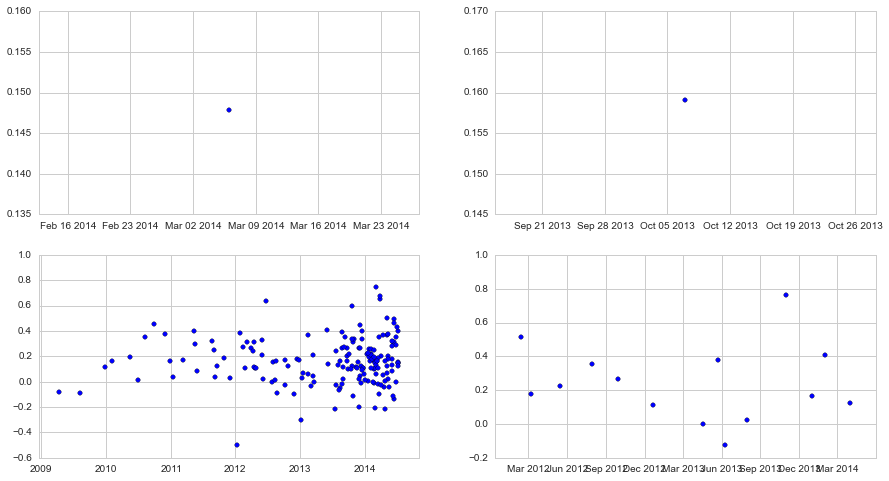

In [387]:
reviews_sentiments_comparision_plot(40)

###So far, we kinda get an idea of how people's sentiment for a certain type of product change over year. Since we are doing this, I want to also do the rating reviews (star-reviews) just to see the consistency between sentiment and overall reviews.

In [389]:
def get_rating_info(i):
    beauty_item_info = {id_list.keys()[i] : id_list.values()[i], 
                        "Rating":[]}
    match_list = rbf.find({"asin":{"$in": [id_list.keys()[i]]}})

    for i in match_list:
        review_time = parser.parse(i['reviewTime'])
        review_rating = i['overall']
        
        beauty_item_info["Rating"].append([review_time,review_rating])
    return beauty_item_info

In [395]:
def rating_comparison_plot(i,k=1):
    fig = plt.figure()
    for i in xrange(i,i+4):
        item_info = get_rating_info(i)
        X = [item_info["Rating"][j][0] for j in range(len(item_info["Rating"]))]
        y = [item_info["Rating"][j][1] for j in range(len(item_info["Rating"]))]
        ax = fig.add_subplot(2,2,k)
        ax.scatter(X,y)
        k += 1

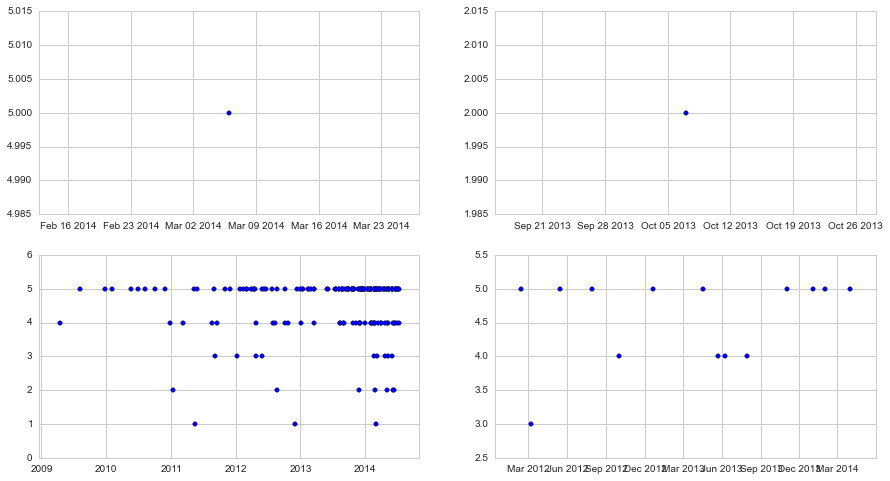

In [396]:
rating_comparison_plot(40)

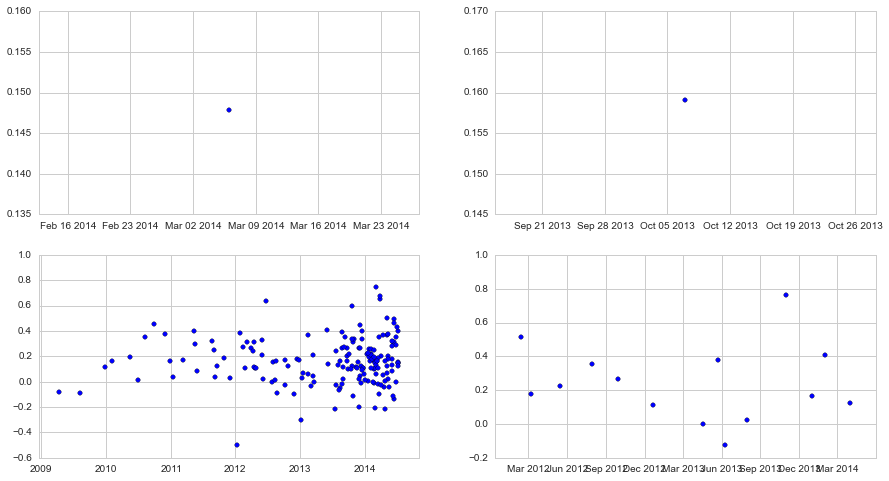

In [397]:
reviews_sentiments_comparison_plot(40)

### Noted the two graphs do show consistency, but the sentiment graph gives you a little bit better idea in how satisfy a person with a product.

##Vectorizing a large text corpus with the hashing trick

In [240]:
from sklearn.feature_extraction.text import HashingVectorizer

In [242]:
hv = HashingVectorizer(n_features=10)
to_matrix = hv.transform(text)

In [243]:
to_matrix.toarray()

array([[ 0.4004907 ,  0.14303239,  0.4004907 , -0.34327774,  0.        ,
        -0.68655548,  0.11442591, -0.05721296, -0.02860648,  0.22885183]])

###We can see that document summarization provides much more informations that are important about a product

####For now, (in my opinion), mean score summary provided better summary of review.

# RATING ALGORITHM

In [65]:
def amazon_rating(x1,x2,x3,x4,x5):
    return (x1+2*x2+3*x3+4*x4+5*x5)/float(x1+x2+x3+x4+x5)

In [66]:
print "50 shades rating", amazon_rating(7708,2732,2970,3584,14876)
print "twightlight rating", amazon_rating(802,349,503,781,4488)
print "the hobbit rating", amazon_rating(141,104,265,1071,6619)
print "daughter of the forest", amazon_rating(20,20,19,73,348)
print "best seller of 2014", amazon_rating(100,108,166,414,1745)
print "divergent", amazon_rating(411,519,1316,3918,14375)
print "eragon", amazon_rating(443,267,331,572,2019)
print "to kill a mocking bird", amazon_rating(141,96,184,657,4708)

50 shades rating 3.47656102918
twightlight rating 4.12725696952
the hobbit rating 4.69792682927
daughter of the forest 4.47708333333
best seller of 2014 4.41966048164
divergent 4.52524465651
eragon 3.95181718062
to kill a mocking bird 4.67559626685


In [67]:
def smooth_rating(x1,x2,x3,x4,x5,alpha,beta):
    return ((x1+2*x2+3*x3+4*x4+5*x5)+alpha*beta)/(float(x1+x2+x3+x4+x5)+beta)

In [68]:
print "50 shades rating", smooth_rating(7708,2732,2970,3584,14876,3,100)
print "twightlight rating", smooth_rating(802,349,503,781,4488,3,100)
print "the hobbit rating", smooth_rating(141,104,265,1071,6619,3,100)
print "daughter of the forest", smooth_rating(20,20,19,73,348,3,100)
print "best seller of 2014", smooth_rating(100,108,166,414,1745,3,100)
print "divergent", smooth_rating(411,519,1316,3918,14375,3,100)
print "eragon", smooth_rating(443,267,331,572,2019,3,100)
print "to kill a mocking bird", smooth_rating(141,96,184,657,4708,3,100)

50 shades rating 3.47507037848
twightlight rating 4.11120603731
the hobbit rating 4.67746987952
daughter of the forest 4.2224137931
best seller of 2014 4.36574249905
divergent 4.51785454722
eragon 3.92631296892
to kill a mocking bird 4.64712878016


In [208]:
def weight_extreme_rating(x1,x2,x3,x4,x5,alpha,beta):
    numer = (2*x1+2*x2+3*x3+4*x4+10*x5)+alpha*beta
    denom = float(2*x1+x2+x3+x4+2*x5+beta)
    return numer/denom

In [70]:
print "50 shades rating", weight_extreme_rating(7708,2732,2970,3584,14876,3,100)
print "twightlight rating", weight_extreme_rating(802,349,503,781,4488,3,100)
print "the hobbit rating", weight_extreme_rating(141,104,265,1071,6619,3,100)
print "daughter of the forest", weight_extreme_rating(20,20,19,73,348,3,100)
print "best seller of 2014", weight_extreme_rating(100,108,166,414,1745,3,100)
print "divergent", weight_extreme_rating(411,519,1316,3918,14375,3,100)
print "eragon", weight_extreme_rating(443,267,331,572,2019,3,100)
print "to kill a mocking bird", weight_extreme_rating(141,96,184,657,4708,3,100)

50 shades rating 3.54118854713
twightlight rating 4.23251847641
the hobbit rating 4.78479415671
daughter of the forest 4.43987341772
best seller of 2014 4.53774006253
divergent 4.67268877911
eragon 4.06700032289
to kill a mocking bird 4.75398230088


In [213]:
#Strict rating weight one-star and two-star reviews twice
#as heavy as the other reviews. 
#This rating method is based on common sense way of people when 
#choosing a product (they care more about flaw of the products than all the good points)
def strict_rating(x1,x2,x3,x4,x5,alpha,beta):
    numer = (2*x1+4*x2+3*x3+4*x4+5*x5)+alpha*beta
    denom = float(2*x1+2*x2+x3+x4+x5+beta)
    return numer/denom

In [212]:
print "50 shades rating", strict_rating(7708,2732,2970,3584,14876,3,100)
print "twightlight rating", strict_rating(802,349,503,781,4488,3,100)
print "the hobbit rating", strict_rating(141,104,265,1071,6619,3,100)
print "daughter of the forest", strict_rating(20,20,19,73,348,3,100)
print "best seller of 2014", strict_rating(100,108,166,414,1745,3,100)
print "divergent", strict_rating(411,519,1316,3918,14375,3,100)
print "eragon", strict_rating(443,267,331,572,2019,3,100)
print "to kill a mocking bird", strict_rating(141,96,184,657,4708,3,100)

50 shades rating 2.9302051403
twightlight rating 3.71580621483
the hobbit rating 4.5842012873
daughter of the forest 4.04677419355
best seller of 2014 4.15733896515
divergent 4.39023598683
eragon 3.5186852769
to kill a mocking bird 4.52163971909


In [88]:
print strict_rating(1,0,3,32,193,2.5,100)
print strict_rating(0,0,1,6,104,2.5,100)
print strict_rating(0,1,7,31,230,2.5,100)
print strict_rating(253,184,297,590,2428,2.5,100)
print strict_rating(101,64,117,205,895,2.5,100)

4.06906906907
3.77725118483
4.19783197832
3.52302631579
3.42258748674


In [87]:
def strict_rating(x1,x2,x3,x4,x5,alpha,beta):
    numer = (3*x1+4*x2+3*x3+4*x4+5*x5)+alpha*beta
    denom = float(5*x1+x2+x3+x4+x5+beta)
    return numer/denom

In [90]:
stopwords = nltk.corpus.stopwords.words('english')

In [93]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

False